In [1]:
import warnings

warnings.filterwarnings(
    'ignore', '.*This code is currently UNREVIEWED, use with caution!.*'
)

In [2]:
import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import matplotlib.pyplot as plt
import numpy as np

from gw_signal_tools.waveform import inner_product, norm, overlap
from gw_signal_tools.PSDs import psd_gw150914

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [3]:
from gw_signal_tools import PLOT_STYLE_SHEET

plt.style.use(PLOT_STYLE_SHEET)

# Inner Product Tutorial

First we need example signals

In [4]:
# Define the dictionary
f_min = 15.0 * u.Hz
f_max = 1024.0 * u.Hz

wf_params = {
    'mass1': 36 * u.solMass,
    'mass2': 29 * u.solMass,
    'deltaT': 1.0 / 2048.0 * u.s,
    'deltaF': 2**-8 * u.Hz,
    'f22_start': f_min,
    'f_max': f_max,
    'f22_ref': 20.0 * u.Hz,
    'phi_ref': 0.0 * u.rad,
    'distance': 440.0 * u.Mpc,
    'condition': 1,  # NEED THIS for consistent comparison of time domain and frequency domain waveforms
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate time domain waveform
hp_t, hc_t = wfm.GenerateTDWaveform(wf_params, gen)

# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, hc_f_fine = wfm.GenerateFDWaveform(wf_params, gen)
hp_f_fine.override_unit(u.s)
hc_f_fine.override_unit(u.s)

Can calculate SNR now, for various PSDs:

In [5]:
from gw_signal_tools.PSDs import psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim

for psd in [psd_gw150914, psd_o3_h1, psd_o3_l1, psd_o3_v1, psd_sim]:
    print(f'SNR for {psd.name}: {norm(hp_f_fine, psd, f_range=[f_min, None])}')

2025-12-20  20:51:21  INFO (inner_product.py: 85): Given lower bound of 15.0 Hz is smaller than values available from given signals. Taking a lower bound of 20.0 Hz instead.


SNR for PSD around GW150914: 33.11355539986595 1 / strain
SNR for Typical PSD of Hanford detector in O3: 53.90871830829185 1 / strain
SNR for Typical PSD of Livingston detector in O3: 62.81075918366114 1 / strain
SNR for Typical PSD of VIRGO detector in O3: 27.08550113801893 1 / strain
SNR for PSD values as simulated by `SimNoisePSDaLIGOZeroDetHighPower`: 92.85058800472106 1 / strain


Also, time domain signals are allowed as input

In [6]:
print(inner_product(hp_t, hp_t, psd_gw150914) ** 0.5)
print(
    inner_product(hp_t, hp_f_fine, psd_gw150914, optimize_time_and_phase=False) ** 0.5
)
print(inner_product(hp_f_fine, hp_f_fine, psd_gw150914) ** 0.5)

2025-12-20  20:51:21  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  20:51:21  INFO (inner_product.py: 266): `signal2` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  20:51:21  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.


33.02609053617223 1 / strain
33.069069877959414 1 / strain
33.11355539986595 1 / strain


Can we expect perfect equality? Let us look at the waveforms

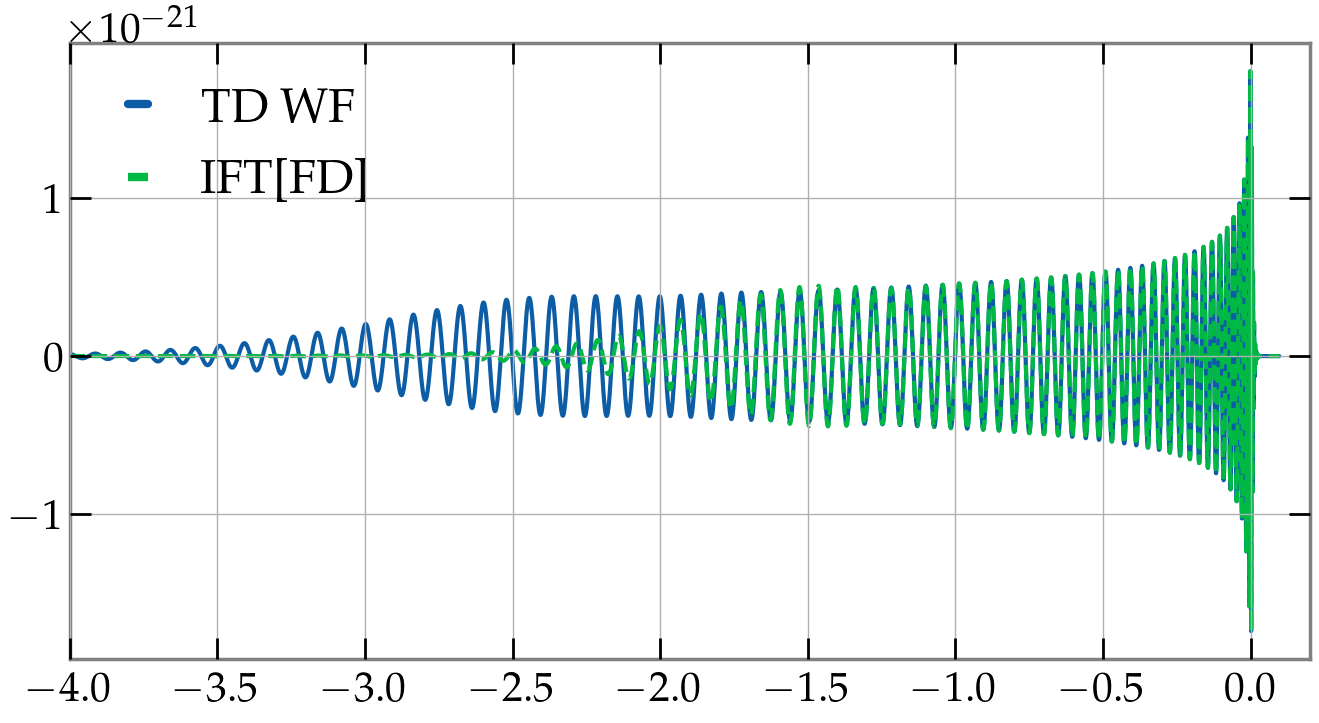

In [7]:
from gw_signal_tools.waveform import fd_to_td

plt.figure(figsize=(16, 8))

plt.plot(hp_t, label='TD WF')
plt.plot(fd_to_td(hp_f_fine), linestyle='dashed', label='IFT[FD]')

plt.xlim(-4, 0.2)
plt.legend(frameon=False)

plt.show()

Evidently, no!
This is due to conditioning that is applied for the time domain generation and kind of an expected feature.
Perhaps more important is how things look in frequency domain

/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/maxmelching/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


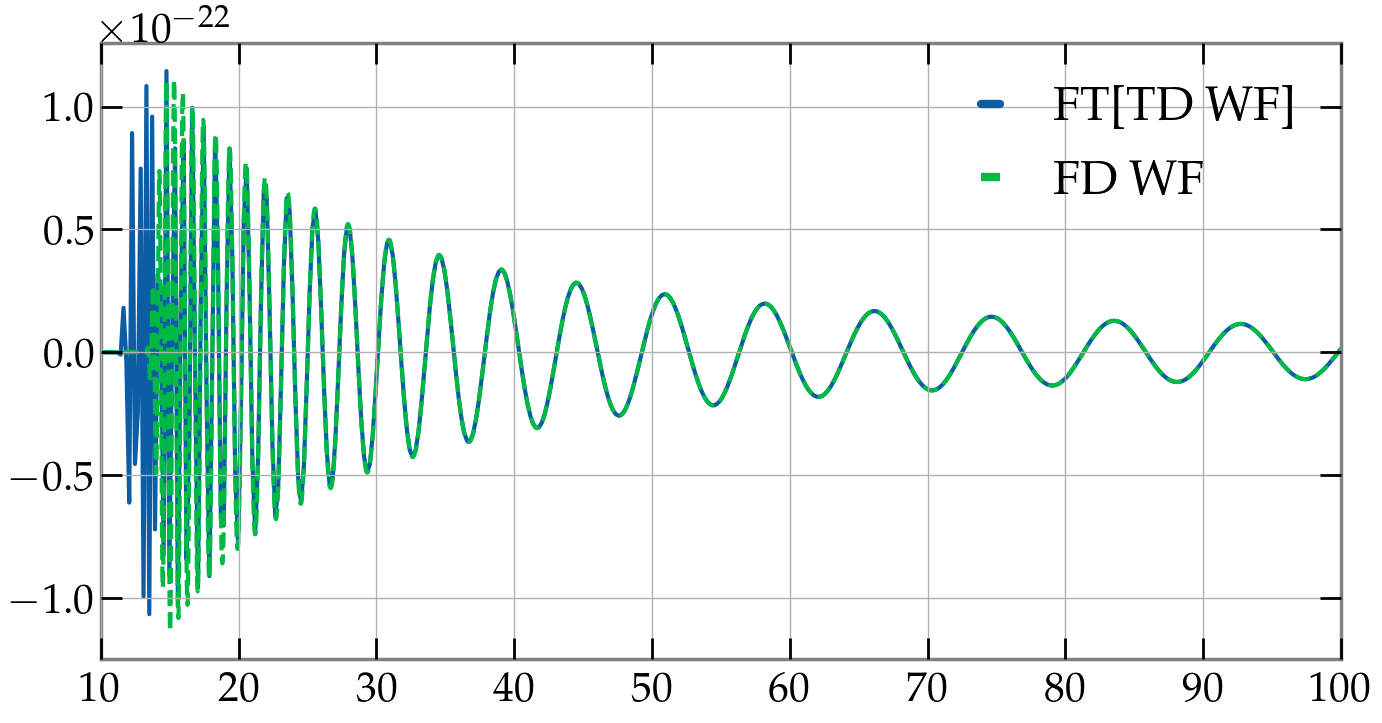

In [8]:
from gw_signal_tools.waveform import td_to_fd

plt.figure(figsize=(16, 8))

plt.plot(td_to_fd(hp_t), label='FT[TD WF]')
plt.plot(hp_f_fine, linestyle='dashed', label='FD WF')

plt.xlim(10, 100)
plt.legend(frameon=False)

plt.show()

Here, too, we have some differences on the low frequency end.
But they are almost entirely below the `f_min` we have specified, so inner products are not affected by that.

Instead, the low frequency end of the Fourier-transformed time domain signal is slightly undersampled.
Once we pad it with zeros in time domain (a nice trick to increase the resolution after a subsequent FT), this improves.

In [9]:
from gw_signal_tools.waveform import pad_to_dx

hp_t_padded = pad_to_dx(hp_t, dx=hp_f_fine.df)

print(inner_product(hp_t_padded, hp_t_padded, psd_gw150914) ** 0.5)
print(
    inner_product(hp_t_padded, hp_f_fine, psd_gw150914, optimize_time_and_phase=False)
    ** 0.5
)
print(inner_product(hp_f_fine, hp_f_fine, psd_gw150914) ** 0.5)

2025-12-20  20:51:22  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  20:51:22  INFO (inner_product.py: 266): `signal2` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.
2025-12-20  20:51:22  INFO (inner_product.py: 257): `signal1` is a ``TimeSeries``, performing an automatic FFT. Due to potential issues with conventions and resolution of the result, this is discouraged, consider doing it manually.


33.11344259446426 1 / strain
33.113498967212735 1 / strain
33.11355539986595 1 / strain


## PyCBC Comparisons

As a reference for the accuracy of the `gw-signal-tools` implementation, let us compare it with one of the widely used other inner product codes, namely the one from the PyCBC library.

In [10]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

from gwpy.frequencyseries.frequencyseries import FrequencySeries

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [11]:
f_low, f_high = f_min.value, f_max.value
sample_rate = 4096

# Enter some arbitrary parameters here
signals_to_compare = {
    'signal1': {'mass1': 10, 'mass2': 10, 'spin1': 0.6, 'spin2': 0.0},
    'signal2': {'mass1': 96, 'mass2': 20, 'spin1': 0.0, 'spin2': 0.1},
}


hp_1_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal1'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0 / sample_rate,
)

hp_2_pycbc, _ = get_fd_waveform(
    approximant=approximant,
    **signals_to_compare['signal2'],
    f_lower=f_low,
    f_upper=f_high,
    delta_f=1.0 / sample_rate,
)

tlen = max(len(hp_1_pycbc), len(hp_2_pycbc))
hp_1_pycbc.resize(tlen)
hp_2_pycbc.resize(tlen)

delta_f = 1.0 / hp_2_pycbc.duration
flen = tlen // 2 + 1
psd_pycbc = aLIGOZeroDetHighPower(flen, delta_f, f_low)


hp_1_pycbc_converted = FrequencySeries.from_pycbc(hp_1_pycbc) * u.s
hp_2_pycbc_converted = FrequencySeries.from_pycbc(hp_2_pycbc) * u.s
psd_pycbc_converted = FrequencySeries.from_pycbc(psd_pycbc) / u.Hz

In [12]:
overlap_normalized_pycbc, i = match(
    hp_1_pycbc,
    hp_2_pycbc,
    psd=psd_pycbc,
    low_frequency_cutoff=f_low,
    high_frequency_cutoff=f_high,
)

print(f'The PyCBC overlap is: {overlap_normalized_pycbc}')

overlap_normalized, info = overlap(
    hp_1_pycbc_converted,
    hp_2_pycbc_converted,
    psd_pycbc_converted,
    f_range=(f_low, f_high),
    optimize_time_and_phase=True,
    return_opt_info=True,
)
peak_time = info['peak_time']
peak_phase = info['peak_phase']

print(f'The gw-signal-tools overlap is: {overlap_normalized}')

print(
    f'The relative difference is: {(overlap_normalized_pycbc - overlap_normalized) / overlap_normalized_pycbc}'
)

The PyCBC overlap is: 0.11853889200071292
The gw-signal-tools overlap is: 0.11853889197578818
The relative difference is: 2.102663725343206e-10


As we can see, the results agree extremely well - which is super encouraging.

## Matches

This comparison was our first application of the match capabilities of `gw-signal-tools`, i.e. the calculation of inner products that are optimized over time and phase.
As a byproduct of such a calculation, we also get the time and phase shift at which this optimal match value is attained.
Testing that this actually works is what we will do next.

In [13]:
time_shift = 0.5 * u.s
phase_shift = 0.8 * u.rad

hp_f_fine_shifted = hp_f_fine * np.exp(
    -2.0j * np.pi * hp_f_fine.frequencies * time_shift + 1.0j * phase_shift
)

overlap_fine, info = inner_product(
    hp_f_fine_shifted,
    hp_f_fine,
    psd_gw150914,
    optimize_time_and_phase=True,
    return_opt_info=True,
)

time = info['peak_time']
phase = info['peak_phase']
match_series = info['match_series']

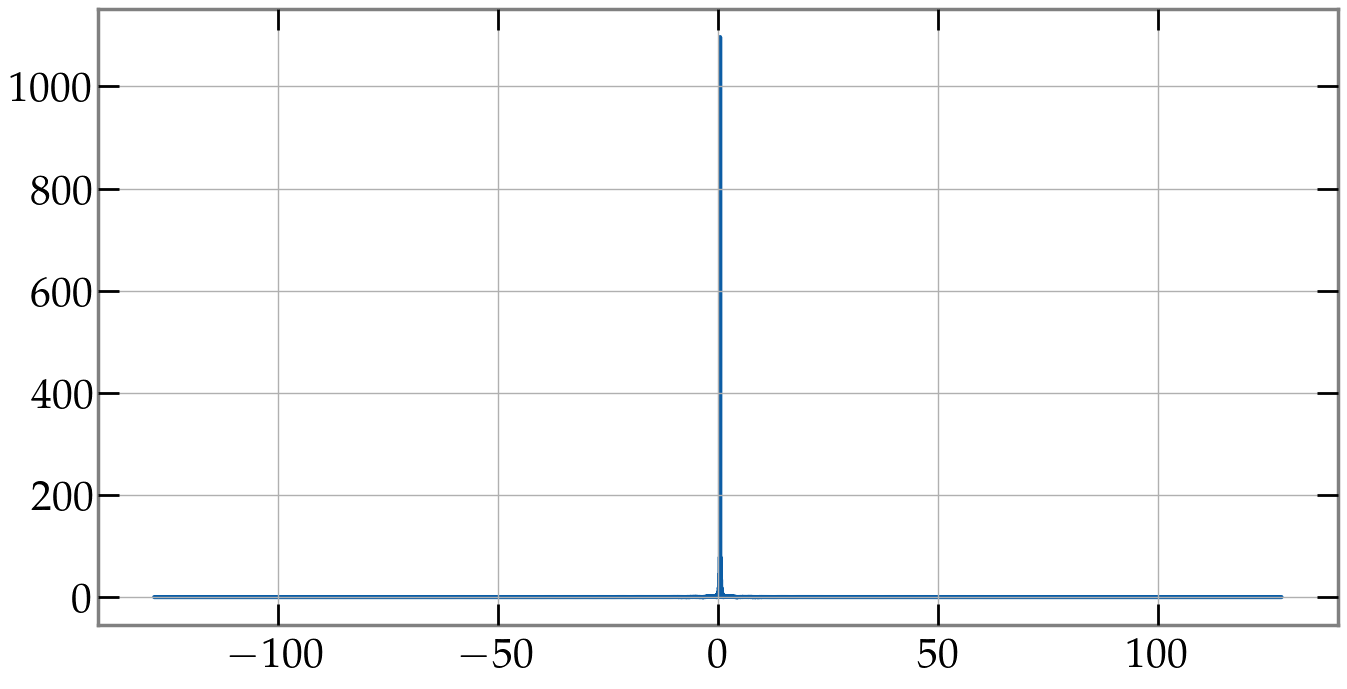

In [14]:
plt.figure(figsize=(16, 8))

plt.plot(match_series.abs())

# plt.xlim(-1, 1)

plt.show()

In [15]:
print(
    f'Match value is {overlap_fine**0.5:.5f}, norm is {norm(hp_f_fine, psd_gw150914):.5f}'
)
print(f'Calculated time shift: {time:.5f}, applied time shift: {time_shift:.5f}')
print(
    f'Difference is t_peak - t_shift = {time - time_shift:.5f}, while resolution is {match_series.dt:.5f}'
)
print(f'Calculated phase shift: {phase:.5f}, applied phase shift: {phase_shift:.5f}')

Match value is 33.11366 1 / strain, norm is 33.11356 1 / strain
Calculated time shift: 0.50000 s, applied time shift: 0.50000 s
Difference is t_peak - t_shift = 0.00000 s, while resolution is 0.00049 s
Calculated phase shift: 0.80000 rad, applied phase shift: 0.80000 rad


Great, the optimized inner product value agrees very well with the value of the non-optimized inner product.
Same goes for the time and phase shift we had introduced.

## Overlap Optimization

Another common task is optimizing inner products over more general parameters, not just time and phase shifts.
`gw-signal-tool` also allows this, through the `optimize_overlap` function.

In [16]:
from gw_signal_tools.waveform import optimize_overlap

In [17]:
def wf_gen(wf_params):
    return wfm.GenerateFDWaveform(wf_params, gen)[0] * u.s


M_shift = 1.0 * u.Msun


def wf_gen_shifted(wf_params):
    wf = (
        wfm.GenerateFDWaveform(
            wf_params | {'mass1': wf_params['mass1'] + M_shift}, gen
        )[0]
        * u.s
    )
    return wf


wf1, wf2, opt_info = optimize_overlap(
    wf_params,
    wf_gen_shifted,
    wf_gen,
    opt_params=['mass1'],
    # min_dt_prec=1e-5*u.s,
)

2025-12-20  20:51:39  INFO (inner_product.py: 1275): Optimization terminated successfully. Remaining waveform mismatch is 1.673951e-10.


In [20]:
print(f'wf_params mass1: {wf_params["mass1"]}')
print(f'Shift {M_shift}')
print(f'Optimized mass1: {opt_info["mass1"]}')

wf_params mass1: 36.0 solMass
Shift 1.0 solMass
Optimized mass1: 36.9999755859375 solMass


There are all sorts of tricks to use during this optimization.
For example, one can add `'time'` and `'phase'` as parameters because this can smooth out how the match behaves as a function throughout the parameter space.

In [29]:
wf1, wf2, opt_info = optimize_overlap(
    wf_params,
    wf_gen_shifted,
    wf_gen,
    opt_params=['mass1', 'time', 'phase'],
    min_dt_prec=1e-5 * u.s,
    df=2**-2 * u.Hz,
)

2025-12-20  21:01:02  INFO (inner_product.py: 1275): Optimization terminated successfully. Remaining waveform mismatch is 7.054990e-11.


In [28]:
print(f'wf_params mass1: {wf_params["mass1"]}')
print(f'Shift {M_shift}')
print(f'Optimized mass1: {opt_info["mass1"]}')

wf_params mass1: 36.0 solMass
Shift 10.0 solMass
Optimized mass1: 45.9999755859375 solMass


Here, it does not seem to be super helpful.
But for other parameter combinations, it can definitely help a ton with obtaining more accurate results.